In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import pandas as pd
import func
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import io, filters, img_as_ubyte
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, patches_root, patches_db_path, train_csv_path, \
post_root, compr_img, noise_img, blur_img

In [4]:
model_list = os.listdir(os.path.join(patches_root, 'test'))

img_path = [] # path of the images
file_name = [] # file name of the images
img_num = [] # number of images of each camera
label_list = []
compr_path = [] # path of compressed images
noise_path = []
blur_path = []

for model in model_list: 
    tmp = os.listdir(os.path.join(patches_root, 'test', model))
    img_num.append(len(tmp))
    file_name += tmp
    img_path += [os.path.join(patches_root, 'test', model, img) for img in tmp]
    # create dir for each camera for every post-processing technique
    for proc in [compr_img, noise_img, blur_img]:
        path = os.path.join(proc, model)
        if not os.path.exists(path):
            os.makedirs(path)
    
for i in range(len(img_num)):
    label_list += [model_list[i]]* img_num[i]

for img, label in zip(file_name, label_list):
    compr_path += [os.path.join(compr_img, label, img)]
    noise_path += [os.path.join(noise_img, label, img)]
    blur_path += [os.path.join(blur_img, label, img)]

In [5]:
# Compress to JPEG, QF = 70
for img, path in zip(img_path, compr_path):
    if not os.path.exists(path):          
        im = Image.open(img)
        im.save(path, 'JPEG', quality=70, optimize=True)

In [6]:
# Adding Gaussian Noise
mean = 0
sigma = 2/255
height, width = (256, 256)

for img, path in zip(img_path, noise_path):
    if not os.path.exists(path): 
        image = io.imread(img)
        noisy = random_noise(image, mode='gaussian', mean=0, var=sigma**2)
        io.imsave(path, img_as_ubyte(noisy), check_contrast=False)

In [7]:
# Adding Gaussian Blur
for img, path in zip(img_path, blur_path):
    if not os.path.exists(path): 
        image = io.imread(img)
        blur = filters.gaussian(image, sigma=1.1, truncate=2.0)
        io.imsave(path, img_as_ubyte(blur), check_contrast=False)

In [8]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

Found 11775 images belonging to 3 classes.

It tooks 4 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,87,26,42
Olympus_mju-1050SW,7,186,11
Nikon_D200,40,58,183


The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.566570,0.167909,0.265521
1.0,0.049934,0.894274,0.055792
2.0,0.156606,0.223625,0.619768


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.450204,0.294853,0.362245
1.0,0.165818,0.240040,0.168849
2.0,0.283094,0.318080,0.384717


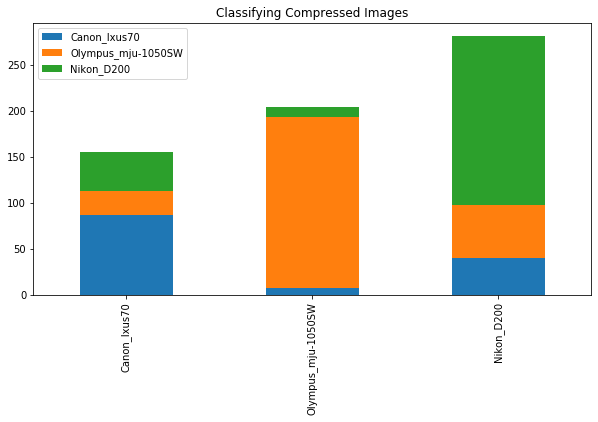

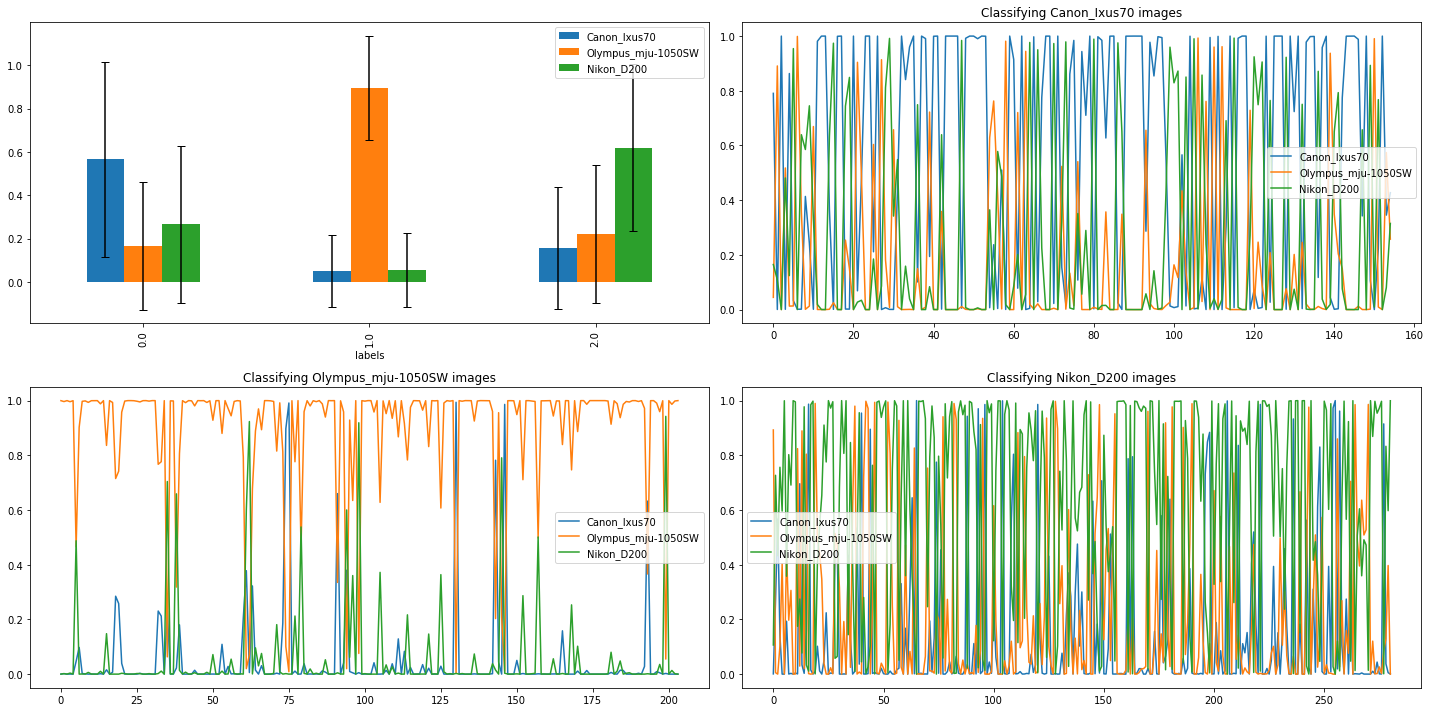

In [9]:
# Read the positive test samples.
compr_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/compr/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(compr_generator)

hist, conf, labels = func.evaluate(model_list, compr_generator, model, index=model_list, columns=model_list, 
                                   title='Classifying Compressed Images', num_batch=10)

mean, error = func.mean_error(labels, conf, model_list)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)
# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
func.plot_conf(model_list, labels, conf, graph)

Found 11779 images belonging to 3 classes.

It tooks 1 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,140,2,0
Olympus_mju-1050SW,112,110,0
Nikon_D200,229,1,46


The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.989094,0.010906,5.257021e-08
1.0,0.503039,0.496929,3.206516e-05
2.0,0.818765,0.005371,1.758640e-01


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.081899,0.081899,5.153960e-07
1.0,0.431597,0.431563,4.178671e-04
2.0,0.349627,0.046454,3.489872e-01


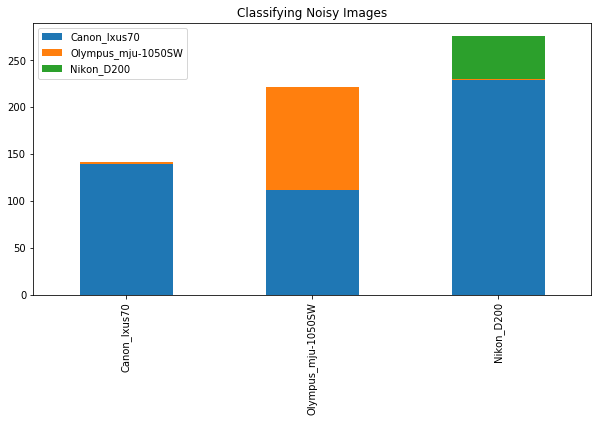

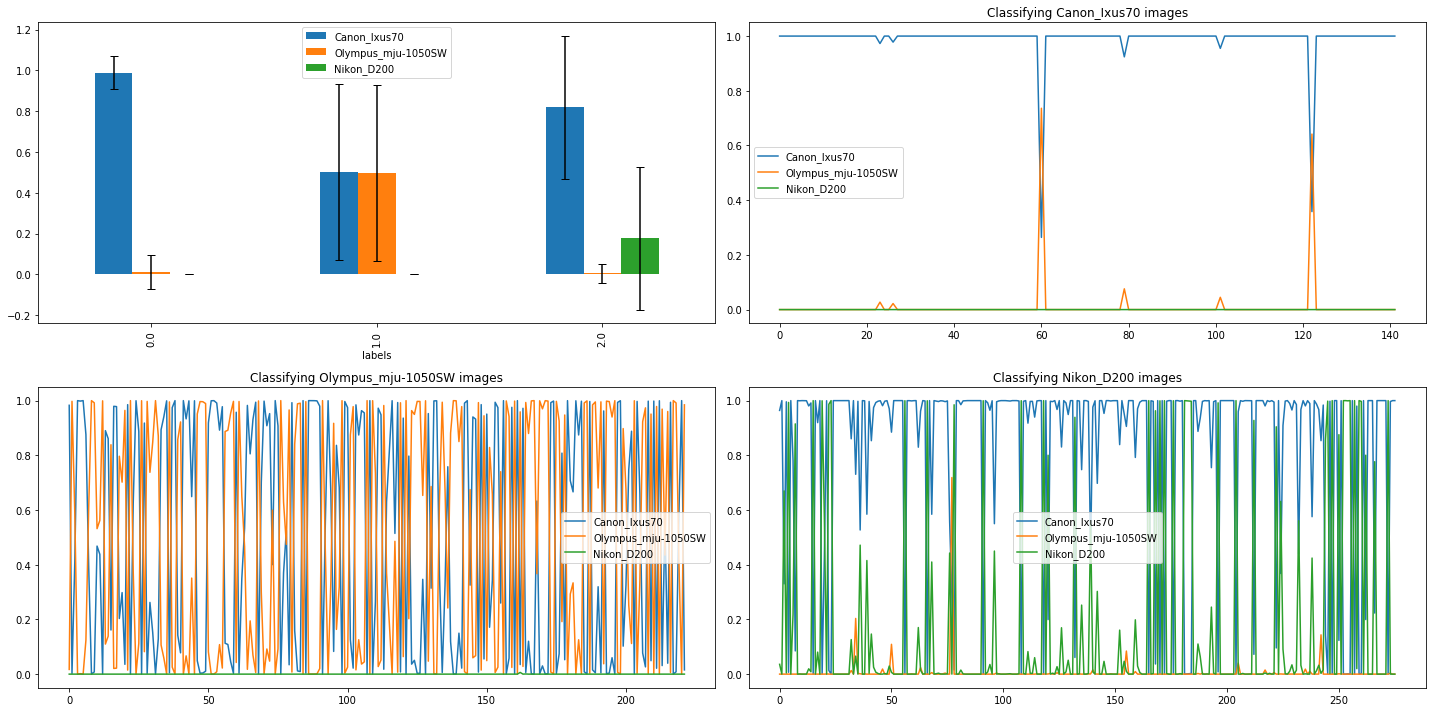

In [10]:
# Read the positive test samples.
noise_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/noise/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(noise_generator)

hist, conf, labels = func.evaluate(model_list, noise_generator, model, index=model_list, columns=model_list, 
                                   title='Classifying Noisy Images', num_batch=10)
mean, error = func.mean_error(labels, conf, model_list)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)
# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
func.plot_conf(model_list, labels, conf, graph)

Found 11778 images belonging to 3 classes.

It tooks 1 seconds

index are predictions, columns are ground truth



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
Canon_Ixus70,0,150,0
Olympus_mju-1050SW,0,210,0
Nikon_D200,0,279,1


The mean of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.000224,0.998994,0.000782
1.0,0.000115,0.998346,0.001539
2.0,0.001443,0.994994,0.003563


The standard deviation of the confidence is: 



,Canon_Ixus70,Olympus_mju-1050SW,Nikon_D200
labels,,,
0.0,0.001115,0.005324,0.005046
1.0,0.000815,0.011358,0.010934
2.0,0.023666,0.059401,0.036993


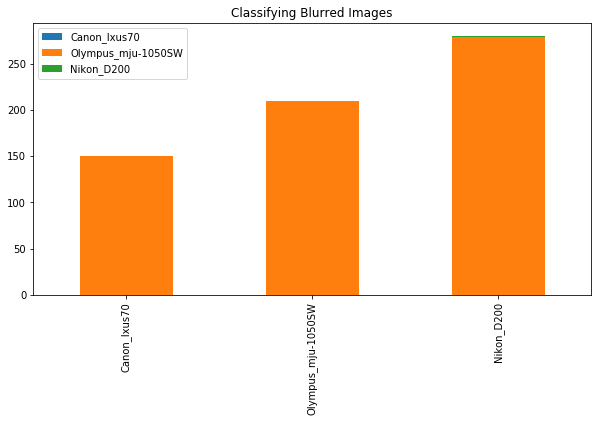

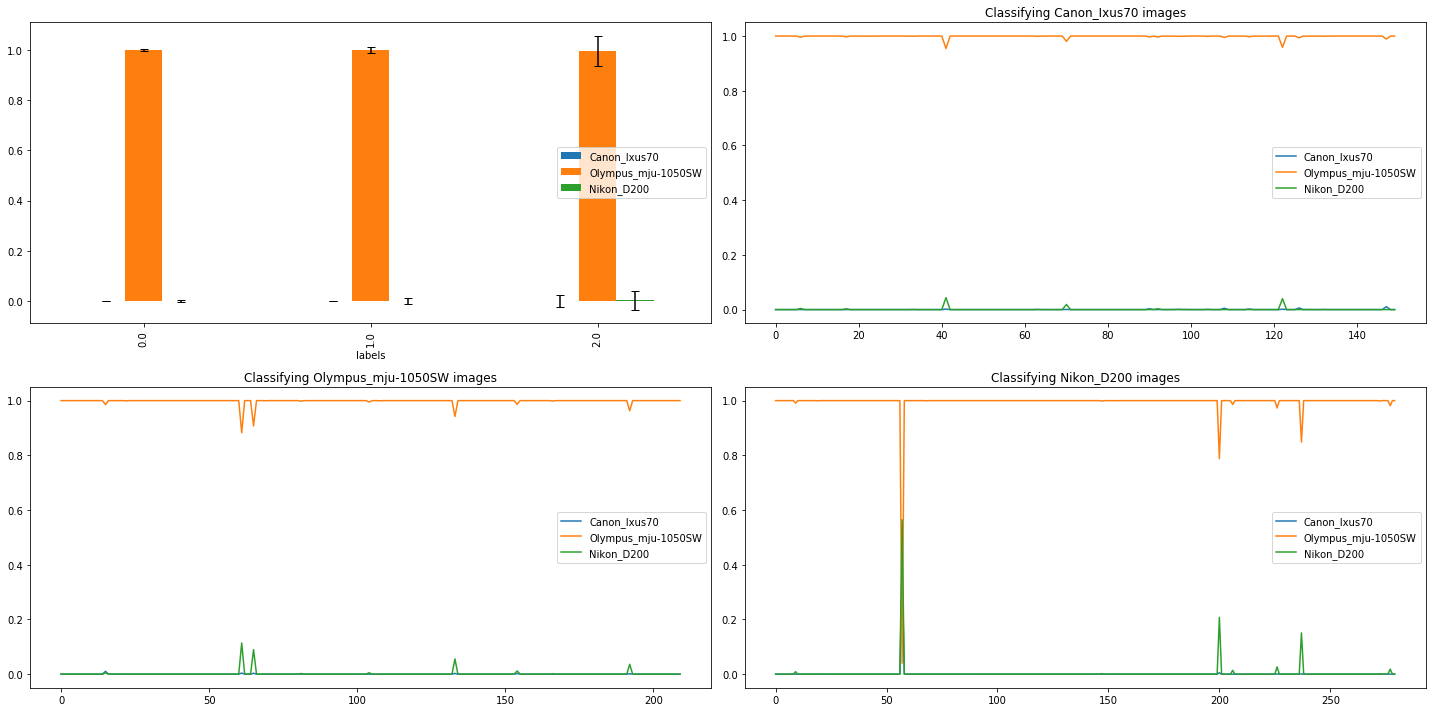

In [11]:
# Read the positive test samples.
blur_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/blur/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(blur_generator)

hist, conf, labels = func.evaluate(model_list, blur_generator, model, index=model_list, columns=model_list, 
                                   title='Classifying Blurred Images', num_batch=10)
mean, error = func.mean_error(labels, conf, model_list)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
mean.plot.bar(yerr=error, ax=axes[0,0], capsize=4)

# for all the images' real label is a certain camera, for example Canon_Ixus70, 
# how does these images are classified ? The magnitude of the histogram indicate how
# sure is the model classified the image as one camera(show by color)
graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
func.plot_conf(model_list, labels, conf, graph)